In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux
from scipy.ndimage import shift
import matplotlib as mpl
from photutils.segmentation import detect_threshold, detect_sources
from photutils.centroids import centroid_com
from photutils.segmentation import deblend_sources
from scipy.spatial import cKDTree
from scipy.stats import norm
from numpy.fft import fft2, ifft2, fftshift
import importlib
from tqdm import tqdm

/usr/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'

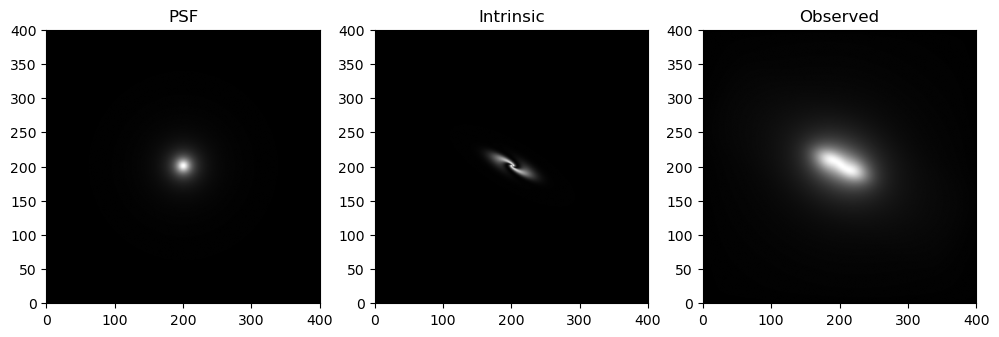

In [4]:
width = 400
height = 400

# Create PSF and Galaxy images
image_psf = moffat(width, height, 1, 10)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [5]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 20, 20)
weight_low_res = gaussian_weight(height//2, width//2, height / 4, width / 4, 10, 10)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, sigma_F = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')

The aperture flux measured using the intrinsic image and weight function : 0.252183
The aperture flux using the observed image and rescaled weight function : 0.252129


/home/deklerk/GAAP/src/analysis.py:72: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.sqrt(np.sum(x_negative ** 2) * np.sum(weight_rescale ** 2) / len(x_negative))


In [6]:
def local_covariance(I, Lx, Ly):
    """
    Compute lag-based covariance C(Δx,Δy) only up to lags Lx, Ly.

    I  : 2D image
    Lx : max lag in x-direction
    Ly : max lag in y-direction
    """
    I0 = I
    H, W = I0.shape
    C_local = np.zeros((2*Lx+1, 2*Ly+1))

    for dx in range(-Lx, Lx+1):
        for dy in range(-Ly, Ly+1):
            # determine overlapping region
            x_start = max(0, -dx)
            x_end   = min(H, H-dx)
            y_start = max(0, -dy)
            y_end   = min(W, W-dy)

            # slices of original and shifted image
            patch1 = I0[x_start:x_end, y_start:y_end]
            patch2 = I0[x_start+dx:x_end+dx, y_start+dy:y_end+dy]

            # average product
            C_local[dx+Lx, dy+Ly] = np.mean(patch1 * patch2)

    return C_local


  0%|          | 0/10 [00:00<?, ?it/s]

 80%|████████  | 8/10 [00:24<00:06,  3.02s/it]


KeyboardInterrupt: 

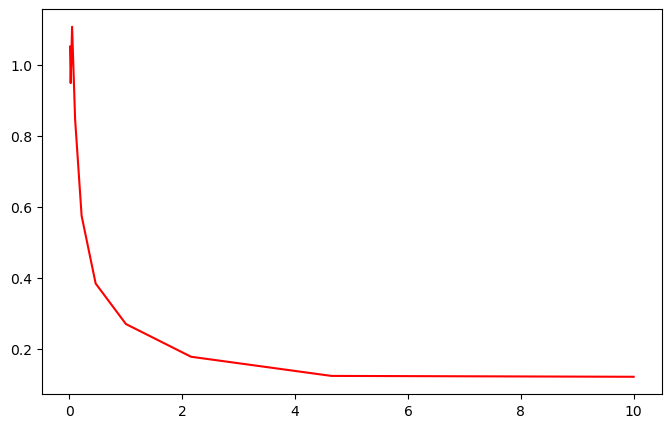

In [7]:
def weighted_variance_lag(s, C_local, Lx, Ly):
    """
    Compute Var(F) = s^T C s using lag-limited covariance C_local
    and weight map s.
    
    s       : 2D weight mask
    C_local : 2D array of size (2*Lx+1, 2*Ly+1)
    """
    V = 0
    H, W = s.shape

    for dx in range(-Lx, Lx+1):
        for dy in range(-Ly, Ly+1):
            # overlapping region indices
            x_start = max(0, -dx)
            x_end   = min(H, H-dx)
            y_start = max(0, -dy)
            y_end   = min(W, W-dy)

            # overlapping slices of weight
            s1 = s[x_start:x_end, y_start:y_end]
            s2 = s[x_start+dx:x_end+dx, y_start+dy:y_end+dy]

            # contribution from this lag
            V += np.sum(s1 * s2) * C_local[dx+Lx, dy+Ly]

    return V

weight_rescaled = np.array(wiener_deconvolution(weight, image_psf, 0))  # ensure numpy array
colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
n_realizations = 100

plt.figure(figsize=(8,5))

for index, size in enumerate(np.arange(1, 10, 1)):
    Lx, Ly = size, size
    a_values = np.logspace(-2, 1, 10)
    ratios = []

    for a in tqdm(a_values):
        # preallocate arrays
        sigma_array = np.zeros(n_realizations)
        flux_array = np.zeros(n_realizations)

        # PSF for correlated noise
        noise_psf = moffat(width, height, 1, a)

        for i in range(n_realizations):
            # generate correlated noise
            noise = np.random.normal(0, 0.001, (height, width))
            noise = fftconvolve(noise, noise_psf, mode="same")

            # compute lag-limited covariance
            C_local = local_covariance(noise, Lx, Ly)

            # compute weighted variance
            V = weighted_variance_lag(weight_rescaled, C_local, Lx, Ly)
            sigma_array[i] = np.sqrt(V)

            # compute weighted flux
            flux_array[i] = np.sum(weight_rescaled * (image + noise))

        # store ratio for this 'a'
        ratios.append(np.mean(sigma_array) / np.std(flux_array))

    # plot as a line with the same color for this size
    plt.plot(a_values, ratios, color=colors[index], label=f'L={size}')

plt.xscale('log')
plt.xlabel('a (correlation scale)')
plt.ylabel('Estimated sigma / Realized sigma')
plt.ylim(0, 2)
plt.legend()
plt.savefig('error_estimation_lagged_covariance.pdf', dpi=300)
plt.show()

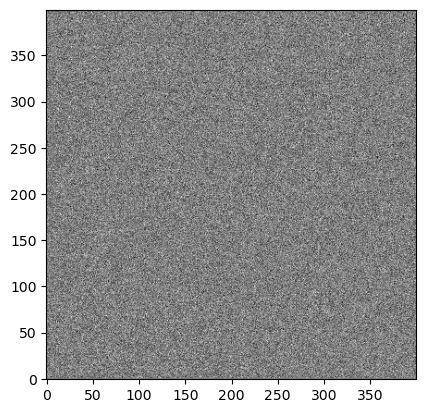

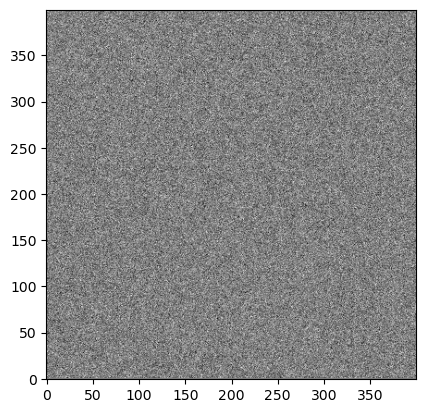

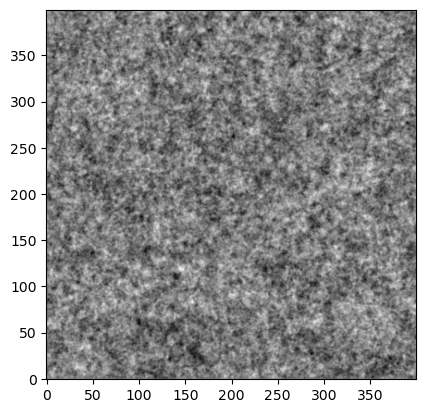

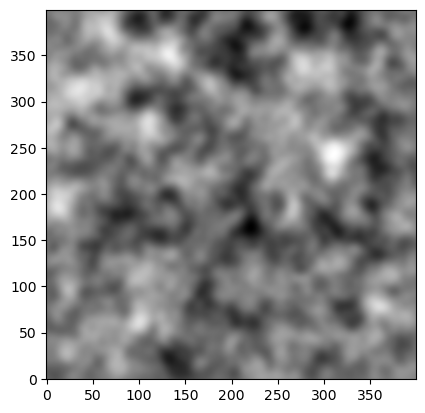

In [8]:
for a in [0.01, 0.1, 1, 10]:
    noise_psf = moffat(width, height, 1, a)
    noise = np.random.normal(0, 10, (height, width))
    noise = fftconvolve(noise, noise_psf, mode="same")
    plt.imshow(noise)
    plt.show()

In [9]:
def local_covariance_negative(I, Lx, Ly):
    """
    Compute lag-based covariance C(Δx,Δy) only up to lags Lx, Ly.

    I  : 2D image
    Lx : max lag in x-direction
    Ly : max lag in y-direction
    """
    I0 = I.copy()
    I0[I0 > 0] = np.nan
    H, W = I0.shape
    C_local = np.zeros((2*Lx+1, 2*Ly+1))
    N = len(I0[~np.isnan(I0)])
    M = len(I0[np.isnan(I0)])
    factor = M*(2*N + M-1) / ((N+M)*(N+M-1))

    for dx in range(-Lx, Lx+1):
        for dy in range(-Ly, Ly+1):
            # determine overlapping region
            x_start = max(0, -dx)
            x_end   = min(H, H-dx)
            y_start = max(0, -dy)
            y_end   = min(W, W-dy)

            # slices of original and shifted image
            patch1 = I0[x_start:x_end, y_start:y_end]
            patch2 = I0[x_start+dx:x_end+dx, y_start+dy:y_end+dy]

            # average product
            C_local[dx+Lx, dy+Ly] = np.nanmean(patch1 * patch2)

    return C_local*factor

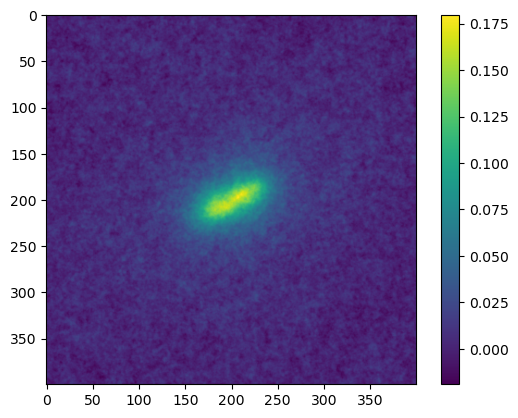

In [ ]:
noise_psf = moffat(width, height, 1, 1)
noise = np.random.normal(0, 0.1, (height, width))
noise = fftconvolve(noise, noise_psf, mode="same")
plt.imshow(image+noise)
plt.colorbar()
plt.show()

In [10]:
noise_psf = moffat(width, height, 1, 1)
noise = np.random.normal(0, 0.1, (height, width))
noise = fftconvolve(noise, noise_psf, mode="same")

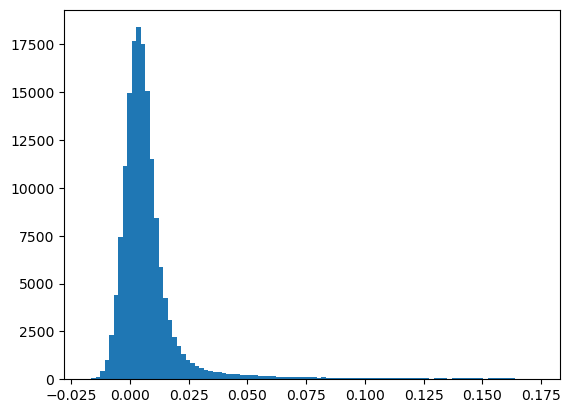

In [12]:
plt.hist((image+noise).flatten(), bins=100)
plt.show()

In [ ]:
def local_covariance_negative(I, Lx, Ly):
    I0 = I.copy()
    I0[I0 > 0] = np.nan
    mask = ~np.isnan(I0)

    H, W = I0.shape
    C_local = np.zeros((2*Lx+1, 2*Ly+1))

    for dx in range(-Lx, Lx+1):
        for dy in range(-Ly, Ly+1):

            xs = max(0, -dx)
            xe = min(H, H-dx)
            ys = max(0, -dy)
            ye = min(W, W-dy)

            A = I0[xs:xe, ys:ye]
            B = I0[xs+dx:xe+dx, ys+dy:ye+dy]

            MA = mask[xs:xe, ys:ye]
            MB = mask[xs+dx:xe+dx, ys+dy:ye+dy]
            Vmask = MA & MB

            T = A.size                  # full denominator
            V = Vmask.sum()             # valid pairs

            if V == 0:
                C_local[dx+Lx, dy+Ly] = 0
                continue

            S = np.nansum(A[Vmask] * B[Vmask])
            C_local[dx+Lx, dy+Ly] = S / T

    return C_local


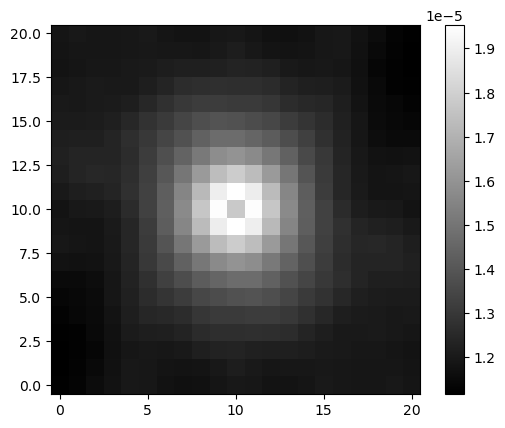

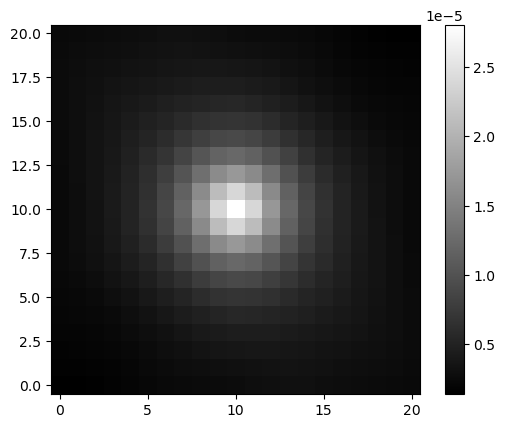

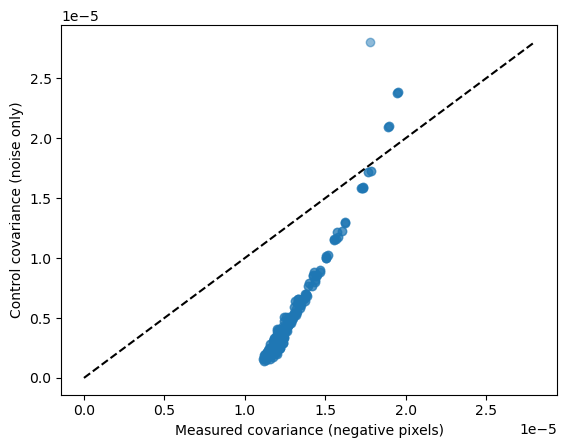

In [25]:
Lx, Ly = 10, 10
I0 = (image+noise).copy()
measured = local_covariance_negative(I0, Lx, Ly)
control = local_covariance(noise, Lx, Ly)
plt.imshow(measured)
plt.colorbar()
plt.show()

plt.imshow(control)
plt.colorbar()
plt.show()
plt.scatter(measured.flatten(), control.flatten(), alpha=0.5)
plt.plot([0, np.max(control)], [0, np.max(control)], 'k--')
plt.xlabel('Measured covariance (negative pixels)')
plt.ylabel('Control covariance (noise only)')
plt.show()


In [27]:
if not None:
    print("o")

o
